# Atividade 2
## Classificação com KNN

Juliano Kendyi Shinohara

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


### Importar csv

In [9]:

df = pd.read_csv('water_potability_nonans.csv')

### Aplicação PCA

Com o dataset importado, são definido os atributos responsáveis para a análise:<br>
• ph<br>
• Sulfate<br>
• Chloramines<br>

Devido o fato do KNN utilizar apenas 2 atributos, através do PCA é realizado uma redução de dimensionalidade dos atributos através do plot pois o PCA é  usado em problemas de redução de dimensionalidade, onde um grande número de variáveis é reduzido a um número menor de variáveis principais.

In [10]:
X = df.loc[:,['ph', 'Sulfate', 'Chloramines']]
y = df.iloc[:, -1]


pca = PCA(n_components=2)
pca.fit(X)


X_pca = pca.transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])

print("Variáveis originais: %s\nVariáveis principais: %s" % (str(X.shape), str(X_pca_df.shape)))


Variáveis originais: (2011, 3)
Variáveis principais: (2011, 2)


<Axes: xlabel='PC 0', ylabel='PC 1'>

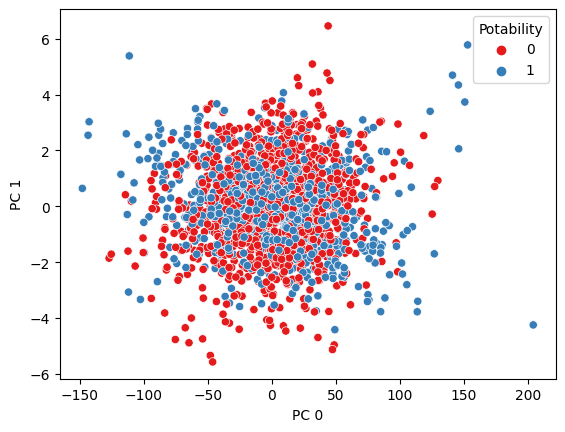

In [11]:

sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

### K Nearest Neighbor

A função realiza testes afim de identificar qual a melhor quantidade de vizinhos (Ks) para a melhor acuracia do treino.

In [12]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val

### K-fold Cross Validation

A validação por K-fold, consiste em dividir o dataset em quantidade de Ks aleatórios, obtendo partições iguais. 
Durante a validação cruzada k-fold, o modelo é treinado em k-1 partes dos dados e testado na parte restante. Este processo é repetido k vezes, com cada parte sendo usada como conjunto de teste uma vez. Os resultados de cada iteração são então calculados para obter uma estimativa do desempenho do modelo. 

In [13]:
k_vias = 8

skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)
acuracias = []

for idx_treino, idx_teste in skf.split(X_pca, y):
    X_treino = X_pca[idx_treino]
    y_treino = y[idx_treino]
    
    X_teste = X_pca[idx_teste]
    y_teste = y[idx_teste]
    
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    knn, _, _ = selecionar_melhor_k(range(1,100,2), X_treino, X_val, y_treino, y_val)
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
print(" min: %.2f\n max: %.2f\n avg +- std: %.2f +- %.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))
  

 min: 0.58
 max: 0.67
 avg +- std: 0.62 +- 0.03


### Grid Search CV

Da mesma maneira feita anteriormente, é realizado, porém com o adicional do GridSearchCV da biblioteca SKLearn, realizando a busca exaustiva do dataset entre os parâmetros, obtendo a acuracia do dataset.

In [7]:
k1 = 8
k2 = 13

skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)
acuracias = []

for idx_treino, idx_teste in skf.split(X_pca, y):
    X_treino = X_pca[idx_treino]
    y_treino = y[idx_treino]
    
    X_teste = X_pca[idx_teste]
    y_teste = y[idx_teste]
    
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    params = {'n_neighbors' : range(1,100,2)}
    knn = KNeighborsClassifier()
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2))
    knn.fit(X_treino, y_treino)
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))

print(" min: %.2f\n max: %.2f\n avg +- std: %.2f +- %.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))


 min: 0.60
 max: 0.66
 avg +- std: 0.63 +- 0.02
